In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.EnvironmentBasics import Environment, Action, State
from utils.GridWorld import GridWorld
from utils.AgentBasics import Agent, Policy
from tqdm import tqdm
from typing import *

# Monte Carlo Method
- 不知道环境如何，或者环境太复杂，state太多，你别想遍历这么多。
- 完全从实践和经验中学习，无数次的探索，然后学习。
- 跟模拟算法是天生的一对。

## First-Visit Monte Carlo Prediction
- 想知道state s遵循policy $\pi$的state-value，$v_\pi(s)$
- 已知有好多episode都经过了s，每次经过s叫做a visit to state s，第一次经过s就叫做first-visit to state s。
- 简单讲，就是每次我到过state s之后都是什么后果，我都给你记着，然后你这个state的好坏就是对我这些后果的平均值。

1. 定义 float Returns\[n_state\]
2. 生成或取得一个episode，即从start state一直到terminal state。
3. G = 0
4. 从后往前循环episode的每一步，得到$(S_{t-1}, A_{t-1}, R_t)$
5. 累积当前state的return $G = \gamma G + R_t$
6. 如果这个state不是这个episode的first-visit，就跳过，否则Returns\[s\].append(G)
7. 回到1
8. 如果你觉得足够了，就停止循环，此时Returns\[s\]是一个list，里面有很多G，它记录着每次经过s得到的未来return，然后求平均值就是$v_\pi(s)$，即一个对state s未来可能取得的return的估计。

首先重写一下GridWorld类，让它的state可以给多个不同的reward，对于普通state，reward在0-1区间，而对于terminal state，其reward在2-3区间

In [2]:
class GridWorldDynamicReward(GridWorld):
    def __init__(self, world_size: int, terminal_states: List[Tuple[int, int]] = None):
        """ Rewrite GridWorld class, make state rewards more random

        :param world_size: size of the world
        """
        state_space = []
        for row in range(world_size):
            for col in range(world_size):
                is_terminal = (row, col) in terminal_states
                # NOLY TERMINAL STATES HAVE REWARDS !!!
                # IF OTHER STATES HAVE REWARDS, THE AGENT WILL BE CONFUSED !!!
                # CAUSION !!! CAUSION !!! CAUSION !!!
                rewards = np.random.rand(4) * is_terminal
                state_space.append(State(f"({row},{col})", rewards=rewards, is_terminal=is_terminal))
        action_space = [Action("left"), Action("right"), Action("down"), Action("up")]
        super().__init__(world_size, terminal_states, state_space, action_space)

    def render(self, agent:Agent=None, figsize:Tuple[int, int]=None):
        """ Render the environment, override method in Environment class
        1. draw the states as grids
        2. no need to draw transitions, because they are obvious in the grid world
        3. highlight current state
        4. highlight start state
        5. highlight terminal states
        """
        if figsize is None:
            figsize = (5, 5)
        plt.figure(figsize=figsize)

        plt.xlim(-1, self.world_size)
        plt.ylim(-1, self.world_size)
        color = agent.state_value if agent is not None else [state.is_terminal for state in self.states]
        plt.scatter(self.grid_colid, self.grid_rowid, c=color, marker="s", s=1000, alpha=0.75)
        # for gi in range(self.n_grids):
        #     label = f"{agent.state_value[gi] if agent is not None else self.states[gi].is_terminal:.2f}"
        #     plt.annotate(label, (self.grid_colid[gi], self.grid_rowid[gi]), textcoords="offset points", xytext=(2, -2), ha="center")

        self.highlightTerminalStates()
        if agent is not None:
            for sid in range(self.n_states):
                if not self.isTerminalState(sid):
                    for action in self.getValidActionIds(sid):
                        row, col = self.stateIdToCoord(sid)
                        self.drawArrow(col, row, action, agent.policy[sid, action])

    def drawArrow(self, x: int, y: int, action: Union[Action, int], length: float = 1):
        """ Draw an arrow from point x, y, direction code: {0: "left", 1: "right", 2: "down", 3: "up"} """
        if not isinstance(action, Action):
            action = self.aid_to_action[action]
        dx, dy = 0, 0
        if action.name == "left":
            dx = -0.5 * length
        elif action.name == "right":
            dx = 0.5 * length
        elif action.name == "down":
            dy = -0.5 * length
        elif action.name == "up":
            dy = 0.5 * length

        plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, length_includes_head=True)

First-Visit Monte Carlo Prediction<p>
在这个设计中，每次循环首先生成了一个episode，每个action的选择使用了根据policy的epsilon-greedy方法，然后从后往前循环episode，累积每个state的return，如果这个state是这个episode的first-visit，就把这个return加入到Returns\[s\]这个list中，然后求平均值，就是这个state的value。<p>
在每次episode的统计结束后，我们根据上述方法更新了state-value，action-value则直接设为了下一个state的value，policy对每个action的选择也是直接根据下一个state的value来选择的。这样我们只需要state-value就可以做选择。<p>


Monte Carlo:   2%|▏         | 48/2000 [00:00<00:04, 474.26it/s]

NOTE: getModelNextStateProbs(state, action) assumes a model exists for the environment.


Monte Carlo: 100%|██████████| 2000/2000 [00:03<00:00, 645.45it/s]


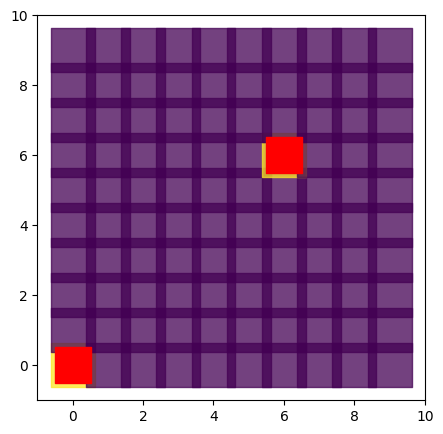

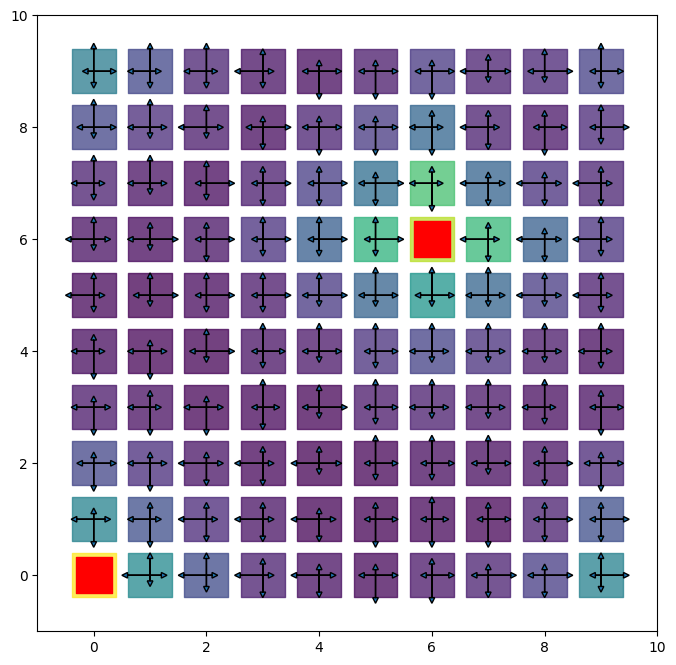

In [3]:
def firstVisionMC(grid_world: GridWorldDynamicReward):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.6

    grid_world.render()

    # Monte Carlo
    # Keep track of the sum of returns G for each state to calculate an average.
    state_return_sum = np.zeros(grid_world.n_states)
    # The number of times each state has been visited. (First visit)
    state_visit_count = np.zeros(grid_world.n_states)
    for it in tqdm(range(2000), desc="Monte Carlo"):
        # Generate episode
        grid_world.reset()  # reset with a random start state
        episode_states = [grid_world.start_sid]
        episode_actions = []
        episode_rewards = []
        
        while not grid_world.isTerminalState(grid_world.current_sid):
            random_action_id = agent.takeAction(grid_world.current_sid, epsilon=0.3)
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            episode_actions.append(random_action_id)
            reward = grid_world.step(random_action_id)
            episode_rewards.append(reward)
            episode_states.append(grid_world.current_sid)
        episode_states = episode_states[:-1]  # remove the last state, which is terminal state


        # Loop state backward to update state value
        G = 0
        for t in range(len(episode_states)-1, -1, -1):
            G = gamma * G + episode_rewards[t]
            if episode_states[t] not in episode_states[:t]:     # check for first visit
                state_return_sum[episode_states[t]] += G
                state_visit_count[episode_states[t]] += 1
                # Update state value
                agent.state_value[episode_states[t]] = state_return_sum[episode_states[t]] / state_visit_count[episode_states[t]]
                # Update policy

                for aid in range(grid_world.n_actions):
                    next_sid = np.where(grid_world.getModelNextStateProbs(episode_states[t], aid) == 1)[0][0]     # only one next state
                    agent.action_value[episode_states[t], aid] = agent.state_value[next_sid]
                    agent.policy[episode_states[t], aid] = agent.state_value[next_sid]
        agent.policy.normalize()

    agent.policy.rankNormalize()

    grid_world.render(agent, figsize=(8, 8))
    plt.show()


firstVisionMC(GridWorldDynamicReward(10, [(0, 0), (6, 6)]))
        

奇怪，这个Monte Carlo方法怎么这么不稳定？？？<p>
一开始，这个很不稳定，是因为我在初始化state space时，将非terminal state的reward设成了0-1区间，terminal state的reward更高，为2-3区间。但这样会导致局部地区有很高的reward，而这个reward是随机的，所以会导致agent在这个地方不断地探索，而不是去探索其他地方。所以我将所有非terminal state的reward都设为0，这样就不会有这个问题了。


# Monte Carlo Estimation of Action Values
如果我们没有model，就不知道环境的dynamics，agent不知道下一个state是什么，那么我们虽然可以计算state-value，但无法计算action-value。<p>
上面代码中的```np.where(grid_world.getNextStateProbs(episode_states[t], aid) == 1)[0][0]```实际上假设我们有model，任何直接访问环境数值的方法都默认使用了model，例如获取action后的下一个state，获取下一个state的reward分布等等。<p>
方法：不再存储然后平均state的visit，而是存储每个state-action pair的visit，然后平均。<p>
重要问题：state-action pair可能太多了，有些state-action pair根本没出现过<p>
解决方法：更多的exploration！可以使用如下方法：<p>

## Exploration Starts
- 从随机的state-action pair开始，然后开始exploration，直到terminal state。

## Monte Carlo Control
其实对一个episode的获取，到更新根据episode来state-value或action-value，这可以看做成Policy Evaluation，因为Policy Evaluation的定义就是根据policy来更新state-value或action-value。<p>
根据之前的Policy Iteration，除了Policy Evaluation，还有Policy Improvement，即根据当前的state-value或action-value来更新policy。<p>
Monte Carlo Control就是Policy Improvement的Monte Carlo版本，即根据当前的state-value或action-value来更新policy。<p>
$$\pi'(s) = \underset{a}{argmax} (Q(s, a))$$
本公式的意思是，对于每个state，选择所有action-value最大的action，作为policy的选择。<p>

Monte Carlo (Action Value): 100%|██████████| 2000/2000 [00:02<00:00, 726.73it/s]


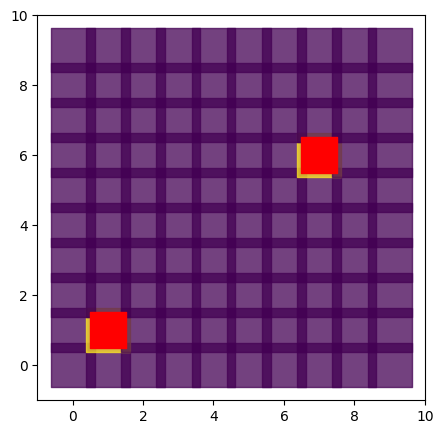

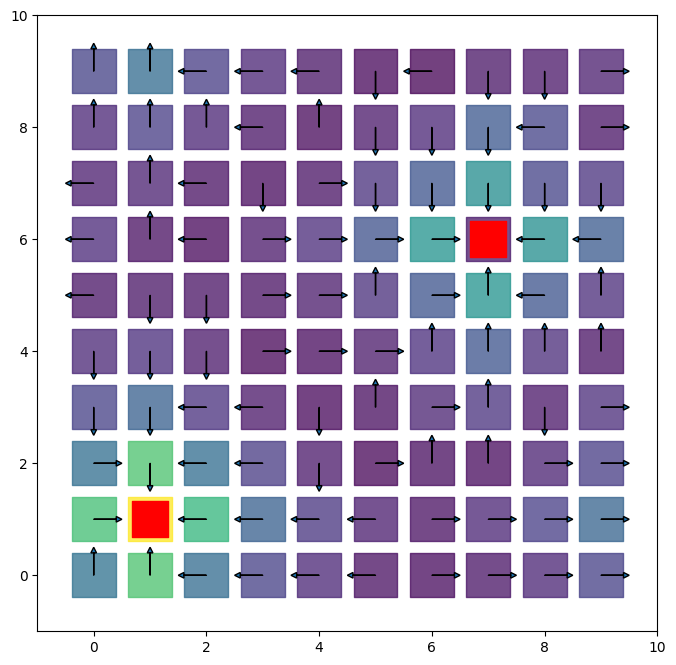

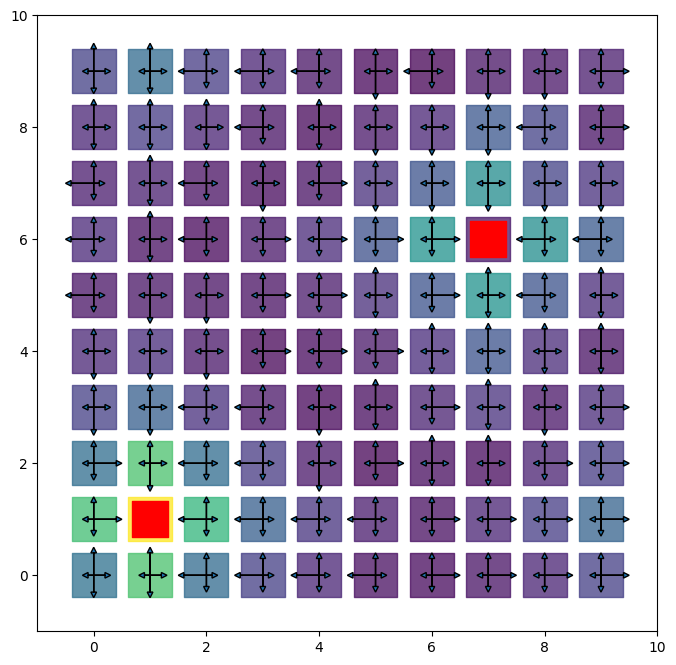

In [4]:
def actionValueFirstVisitMC(grid_world: GridWorldDynamicReward):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.6

    grid_world.render()

    # Monte Carlo
    # Keep track of the sum of returns G for each state-action pair to calculate an average.
    state_value_return_sum = np.zeros((grid_world.n_states, grid_world.n_actions))
    # The number of times each state-action pair has been visited. (First visit)
    state_value_visit_count = np.zeros((grid_world.n_states, grid_world.n_actions))
    for it in tqdm(range(2000), desc="Monte Carlo (Action Value)"):
        # Generate episode
        grid_world.reset()  # reset with a random start state
        episode_states = [grid_world.start_sid]
        episode_actions = []
        episode_rewards = []

        while not grid_world.isTerminalState(grid_world.current_sid):
            random_action_id = agent.takeAction(grid_world.current_sid, epsilon=0.3)
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            episode_actions.append(random_action_id)
            reward = grid_world.step(random_action_id)
            episode_rewards.append(reward)
            episode_states.append(grid_world.current_sid)
        episode_states = episode_states[:-1]  # remove the last state, which is terminal state


        # Loop state backward to update state value
        G = 0
        for t in range(len(episode_states)-1, -1, -1):
            G = gamma * G + episode_rewards[t]
            if episode_states[t] not in episode_states[:t]:     # check for first visit
                state_id = episode_states[t]
                action_id = episode_actions[t]
                state_value_return_sum[state_id, action_id] += G
                state_value_visit_count[state_id, action_id] += 1
                # Update state value (no need to update state value)
                # agent.state_value[episode_states[t]] = state_return_sum[episode_states[t]] / state_visit_count[episode_states[t]]
                # Update action value and policy
                agent.action_value[state_id, action_id] = state_value_return_sum[state_id, action_id] / state_value_visit_count[state_id, action_id]
                # This part is Monte Carlo Control
                agent.policy.makeGreedyTo(agent.action_value, state_id)
                
                # Just make state-value equal to the best action-value of the action can be taken from this state
                # This is not necessary, but otherwise the state-values do not have values
                # Plus our visualization depends on state-values
                agent.state_value[state_id] = np.max(agent.action_value[state_id])

                # Now we cannot access next state, because we don't know the model
                # for aid in range(grid_world.n_actions):
                #     next_sid = np.where(grid_world.getModelNextStateProbs(episode_states[t], aid) == 1)[0][0]
                #     agent.action_value[state_id]
                #     agent.action_value[episode_states[t], aid] = agent.state_value[next_sid]
                #     agent.policy[episode_states[t], aid] = agent.state_value[next_sid]

    
        agent.policy.normalize()
    grid_world.render(agent, figsize=(8, 8))
    plt.show()

    agent.policy.rankNormalize()
    grid_world.render(agent, figsize=(8, 8))
    plt.show()

actionValueFirstVisitMC(GridWorldDynamicReward(10, [(1, 1), (6, 7)]))

第2张图是greedy的policy<p>
第3张图是policy不唯一的(按排名来)<p>
第2张图才是实际的运行结果，因为policy中涉及到了max，因此policy就是这样很极端的愣头青<p>